## Notebook for Figure 4 and related content: Beta Cells Subpopulations
### Author: J. Camunas-Soler
### Last Updated: Feb. 2020

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from singlet.dataset import Dataset
from singlet import SampleSheet, CountsTable
%matplotlib inline

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


In [3]:
%run ./../functions/helper_functions.py
%run ./../functions/predictions.py

In [4]:
root_folder = './../data/'
analysis_folder = './../analysis/'
figures_folder = './../figures/fig4/'

## Load Data

In [5]:
dict_phenotype_norm = {'CellSize_pF': 'Cell size',
                   'NormalizedTotalCapacitance_fF/pF': 'Total Exocitosis',
                   'NormalizedFirstDepolarizationCapacitance_fF/pF': 'Early exocytosis',
                   'NormalizedLateDepolarizationCapacitance': 'Late exocytosis',
                 'CalciumIntegralNormalizedtoCellSize_pC/pF': 'Ca2+ entry',
                   'CapacitanceNormalizedtoCalcium_fF/pC': 'Exocytosis norm Ca2+',
                   'NormalizedEarlyPeakCalciumCurrentAmplitude_pA/pF': 'Early Ca2+ current',
                 'NormalizedLateCalciumCurrentAmplitude_pA/pF': 'Late Ca2+ current',
                   'NormalizedLateCalciumChannelConductance_pS/pF' : 'Late Ca2+ Conductance',
                   'ReversalPotentialbyramp_mV': 'Reversal potential',
                   'NormalizedPeakSodiumCurrentAmplitude_pA/pF': 'Peak Na+ current',
                  'NormalizedSodiumChannelConductance_pS/pF': 'Na+ conductance'}

phenotype_norm = ['Cell size', 'Total Exocitosis','Early exocytosis','Late exocytosis',
                          'Ca2+ entry','Exocytosis norm Ca2+', 'Early Ca2+ current','Late Ca2+ current',
                          'Late Ca2+ Conductance','Reversal potential','Peak Na+ current','Na+ conductance']

In [6]:
#Load and reformat patch-seq dataset
filename =  root_folder + 'patchclamp_wcryo_human.counts.tab'
metadata = root_folder + 'patchclamp_wcryo_human.metadata.tab'

test = pd.read_csv(filename,sep='\t')
annotation = pd.read_csv(metadata,'\t')
annotation = annotation.drop(['cell_type'],axis=1)

annotation['DiabetesStatus'].replace({'heathy': 'healthy'}, inplace=True)
annotation['DiabetesStatus'].replace({'elevated HbA1c': 'T2D'}, inplace=True)
#add cell type information already computed
ct_all = pd.read_csv(analysis_folder + 'cell_typing_merged.csv', sep='\t', index_col=0, names=['cell_type'])
ct_FACS = pd.read_csv(analysis_folder +'cell_typing_FACS_endocrine.csv', sep='\t', index_col=0, names=['cell_type'])
ct_all = pd.concat([ct_all,ct_FACS])
annotation = annotation.join(ct_all['cell_type'], on='name')

annotation.rename(columns=dict_phenotype_norm, inplace=True)
#remove commas from data ephys
annotation[phenotype_norm] = annotation[phenotype_norm].apply(lambda x: pd.to_numeric(x.astype(str)
                                                   .str.replace(',',''), errors='coerce'))
annotation[phenotype_norm] = annotation[phenotype_norm].astype(float)

#remove genes not seen in 5 cells or having 10 counts total
test= filter_genes_pp(test, min_cells=5, min_counts=10)
#create dataset
ds = Dataset(counts_table=CountsTable(test),samplesheet=SampleSheet(annotation))
#remove nans in glucse
ds.samplesheet = ds.samplesheet[~ds.samplesheet[['Glucose_mM']].isnull().values]
#save unnormalized table
ds_pclamp_raw = ds.copy()
# Get data and normalize gene expression to combine cell size plot and marker genes
ds_norm = ds.copy()
ds_norm.counts = ds_norm.counts.normalize()
ds_norm.counts.pseudocount = 1
ds_norm.counts = ds_norm.counts.log(base=2)
ds_norm.counts.pseudocount = 1
ds_norm_pclamp = ds_norm.copy()

filter_condition = {'Cryopreserved': ['Yes']}
ds_t1d = filter_samplesheet(ds_norm, filter_dict= filter_condition)

filter_condition = {'Cryopreserved': ['No']}
ds_pclamp = filter_samplesheet(ds_norm, filter_dict= filter_condition)

## RBP4 subpopulations show variation in Na+ currents and ABCC9 expression

In [7]:
filter_condition = {'cell_type': ['beta'], 
                    'DiabetesStatus': ['healthy'],
                   'Patched': ['Yes'],#,
                   'TimefromDispersion_days': [1,2,3,4],
                   'Glucose_mM': [5,10]}#,
                  # 'Glucose_mM': [1,5,10]}
'''filter_condition = {'cell_type': ['beta'], 
                    'DiabetesStatus': ['healthy']}#,'''
filtered_dataset = filter_samplesheet(ds_pclamp, filter_dict= filter_condition)
ts = filtered_dataset

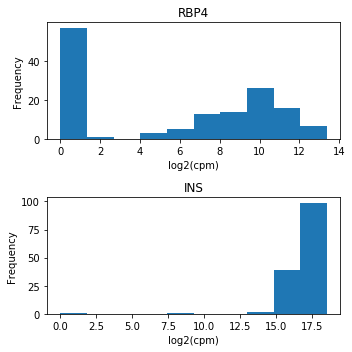

In [8]:
#add column to dataset based on gene expression of RBP4 
# we see below that a good threshold to filter RBP4 negative beta-cells is in the range log2cpm = 2, as we find a bimodal distribution
genes = ['RBP4','INS']
fig, axs = plt.subplots(2,1, figsize=(5,5))
axs = axs.flatten()
for i,gene in enumerate(genes):
    ts.counts.loc[gene,:].T.plot(kind='hist',ax=axs[i], title=gene)
    axs[i].set_xlabel('log2(cpm)')
fig.tight_layout(w_pad=0.2)
#fig.savefig('./cutoff_selectedgenes.png')
ts = add_column_based_gene_expression(ts,gene='RBP4',threshold=2)

/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/pandas/core/reshape/reshape.py:731: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  frame = frame.loc[:, id_vars + value_vars]
/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

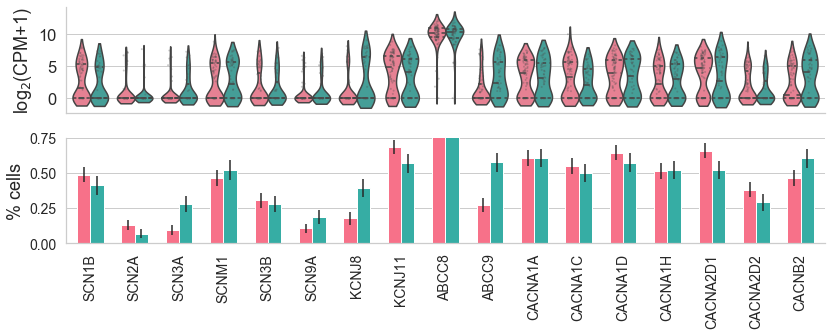

In [9]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
groupby_col = 'gene_group_RBP4'
groups = ['RBP4+','RBP4-']
thres=2
genes = genelist = [ 'SCN1B', 'SCN2A', 'SCN3A',
       'SCNM1', 'SCN3B', 'SCN9A','KCNJ8','KCNJ11','ABCC8','ABCC9','CACNA1A','CACNA1C','CACNA1D','CACNA1H','CACNA2D1','CACNA2D2','CACNB2']

n_par = len(genes)
n_size = 0.7* n_par
fig,axs= plt.subplots(nrows=2, ncols=1, figsize=(n_size,5),sharex=True,gridspec_kw = {'height_ratios':[1, 1]})
axs=axs.flatten()

filter_cols = [groupby_col]
plot_test = ts.samplesheet.loc[:, filter_cols].copy()
plot_testb = ts.counts.loc[genes,:].T.copy()
plot_test = pd.concat([plot_test,plot_testb],axis=1)


data = plot_test.melt(id_vars=['cell_type',groupby_col], value_vars=genes, var_name='gene',value_name='log2(CPM)')


axs[0] = sns.violinplot(x='gene', y='log2(CPM)', data=data, hue=groupby_col, 
                        ax=axs[0], cut=1, linewidth=1.5, palette='husl',alpha=1,inner='quartile',scale='width')#
axs[0] = sns.stripplot(x='gene', y='log2(CPM)', data=data, hue=groupby_col, jitter=True, alpha=0.3, dodge=True, ax=axs[0],palette=['0.3','0.3','0.3','0.3'],s=2)
axs[0].set_yticks([0,5,10])

axs[0].set_ylabel(r'log$_2$(CPM+1)')
axs[0].set_xlabel('')
axs[0].xaxis.set_visible(False)
axs[0].legend().set_visible(False)
    

#prepare melted dataset
t = melt_datataset_gene_ephys(ds=ts, gene_list=genelist, samplesheet_columns=[groupby_col])
means={}
sds={}
for group in groups:
    s = t[t[groupby_col].isin([group])]
    s.drop(groupby_col,axis=1,inplace=True)
    mean, sd = percent_expression_bootstrap_rows(df=s, n_iterations=500, thres=thres)
    means[group] = mean
    sds[group] = sd
means = pd.DataFrame(means)
sds = pd.DataFrame(sds)


cmap = make_colormap_from_palette('husl')
means.plot(kind='bar',yerr=sds, width=0.6,fontsize=14,colormap=cmap,ax=axs[1])

axs[1].set_ylim(0,0.75)
axs[1].set_ylabel('% cells')
axs[1].grid(b=None, which='major', axis='x')
axs[1].legend().set_visible(False)
  
sns.despine()
fig.tight_layout()
fig.savefig(figures_folder +'fig4a_genes.pdf')

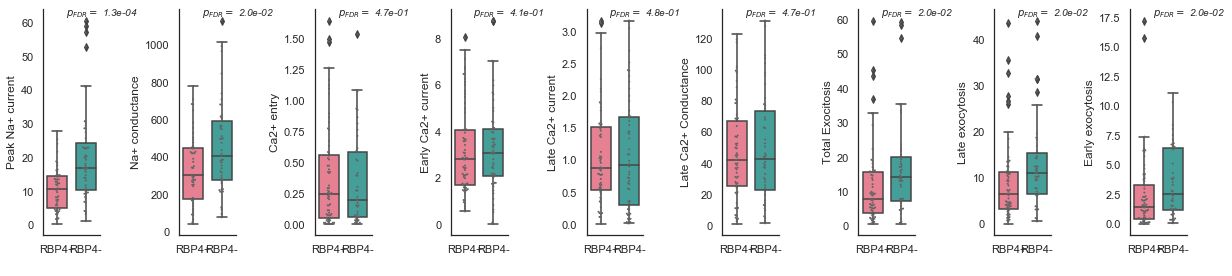

In [10]:
sns.set(font_scale=1)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')

pars = [ 'Peak Na+ current',
        'Na+ conductance',
        'Ca2+ entry',
        'Early Ca2+ current',
        'Late Ca2+ current',
        'Late Ca2+ Conductance',
        'Total Exocitosis',
        'Late exocytosis',
        'Early exocytosis',]

cols = pars + [groupby_col]

qlow=0.03
qhigh=0.97

x = filter_quantile_values(ts.samplesheet, columns=pars, qlow=qlow,qhigh=qhigh, include_quantiles=False)
for par in pars:
    if x[par].mean() < 0:
        x[par] = -1*(x[par])
    #clip value of electrophysiology to zero, no negative values
    x[par] = x[par].clip(lower=0)

#mask zero values
x[pars] = x[pars].mask(x[pars]<=0)
#prepare melted dataset
t = x[cols]


fig,axs= plt.subplots(nrows=1,ncols=9,figsize=(17,4))
axs = axs.flatten()

pvals = df_get_mu_pvals(t, pars=pars, column_class=groupby_col,categories=groups)
new_pal= ['#636363','#636363']
for i,par in enumerate(pars):
    sns.boxplot(y=par, data=t,x=groupby_col,ax=axs[i],palette='husl', width=0.7)
    sns.swarmplot(y=par, data=t,x=groupby_col,ax=axs[i], palette=new_pal,size=2)
    axs[i].text(0.4,0.97, r'$p_{{FDR}}=$ {:.1e}'.format(pvals.loc[par,'FDR']), style='italic',fontsize=10, transform = axs[i].transAxes)
    axs[i].set_xlabel(' ')
    if par =='Exocytosis norm Ca2+':
        axs[i].set_ylim(-1,100)

sns.despine()
fig.tight_layout()
fig.savefig(figures_folder +'fig4b_ephys.pdf')